# Train and Compare Machine Learning Models
* To succecfully run this notebook you need a python3.7 kernel with requirements in ./sagemaker-custom-image/requirements.txt

## This notebook will help you to do:
* Import train and test data
* Run many ML algorithms using SageMaker Autopilot
* Run many ML algorithms using H2O AutoML
* Compare all model performance in test dataset
* Choosing and save the best model

# 1. Parameters

In [80]:
#Name
ModelName = 'hr_analytics'
#Version
ModelVersion = 'v1'

#Model ID
ModelId = ModelName+'_'+ModelVersion

#Setting the model target variable name
VarTarget = 'is_promoted'
VarId = 'employee_id'
VarDate = 'reference_date'

#process outputs such as MOJO model, images and performance of tested models
OutputPath = './output_model/'

#If you have a huge dataset, I should consider use a small sample for first execution
PctSampleSize = 1

CAT = ['department'
,'region'
,'education'
,'gender'
,'recruitment_channel'
,'kpis_met_80']

#float
#Testar as variaveis no_of_trainings e previous_year_rating como categorcias e ver se melhora o modelo
NUM = ['no_of_trainings'
,'previous_year_rating'       
,'age'
,'length_of_service'
,'avg_training_score'
]
selected_features = CAT + NUM

# 2. Import Libraries

In [81]:
import sys
sys.path.append('/anaconda/envs/azureml_py38/lib/python3.8/site-packages')

import functools
import os
from time import gmtime, strftime, sleep
import datetime as dt
import pandas as pd
import numpy as np
import glob
import boto3
import h2o
import matplotlib.pyplot as plt
from sklearn import metrics
import shutil
import seaborn as sns
from io import StringIO
from sklearn.model_selection import train_test_split
from keras import Sequential
from keras.layers import Dense
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# 3. Importing Data for Modeling

In [82]:
dataprep_df_full = pd.read_csv('./HR_Analytics/dataprep_df.csv')
normalized_and_dummy_df = pd.read_csv('./HR_Analytics/normalized_and_dummy_df.csv')

In [83]:
#Work with a sample data if the PctSampleSize is less than 1
if PctSampleSize == 1:
    dataprep_df = dataprep_df_full.copy()
else:
    dataprep_df = dataprep_df_full.sample(frac=PctSampleSize, replace=False, random_state=1)
del dataprep_df_full

In [84]:
#Numeric features must be float type
for col_name in NUM:
    dataprep_df[col_name] = dataprep_df[col_name].astype(float)

#Categorical features must be string type and null values will be filled with "missing"
for col_name in CAT:
    dataprep_df[col_name] = dataprep_df[col_name].astype(str)

In [85]:
#Include the new variables
normalized_and_dummy = []
for i in normalized_and_dummy_df.columns:
    if (i.startswith('dummy_')) or (i.startswith('normalized_')):
        normalized_and_dummy.append(i)

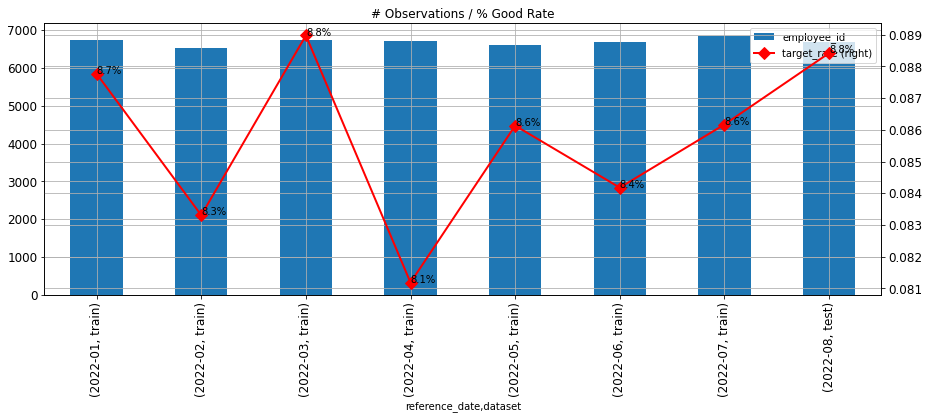

In [86]:
#plot the final dataset with time period, train and test definitions
dataprep_target = dataprep_df[[VarDate, VarId, VarTarget, 'dataset']].groupby(by=[VarDate, 'dataset']).agg({VarId:'count', VarTarget:'sum'})
dataprep_target['target_rate'] = dataprep_target[VarTarget] / dataprep_target[VarId]


dataprep_target[VarId].plot(secondary_y=False, kind='bar', rot=90, figsize=(15,5), linewidth=2, fontsize=12, grid=True, legend=1, title=("# Observations / % Good Rate"))
ax = dataprep_target.target_rate.plot(secondary_y=True, kind="line", rot=90, figsize=(15,5), linewidth=2, fontsize=12, marker="D", ms=8, grid=True, color='r', legend=1)
for p in range(len(dataprep_target)):
    ax.annotate(str('{0:.1%}'.format(int(dataprep_target.reset_index().iloc[p,4]*1000)/1000)), (dataprep_target.reset_index().index.values[p], dataprep_target.reset_index().iloc[p,4]*1))

## 3.1 Treatment of Numeric Missing Data

In [87]:
#Create the "Missing" category for missing values in string vaviables
# dataprep_df = dataprep_df.apply(lambda x: x.fillna(np.nan) if x.dtype.kind in 'biufc' else x.fillna('Missing'))

In [88]:
#Tratamento da idade
# dataprep_df['age_mean'] = dataprep_df['age'].fillna(dataprep_df['age'].mean())

## 3.2 Outliers Removing

In [89]:
# var = 'max_salary_offered_to_prev_application'

# q_low = dataprep_df[var].quantile(0.00012)
# q_hi  = dataprep_df[var].quantile(0.9999)
# print('Low: ' + str(q_low))
# print('High: ' + str(q_hi))
# print('Reduction: '
#       + "{0:.2%}".format(len(dataprep_df[(dataprep_df[var] <= q_hi) & (dataprep_df[var] >= q_low)])/len(dataprep_df)-1)
#       + " | "
#       + str(len(dataprep_df)-len(dataprep_df[(dataprep_df[var] <= q_hi) & (dataprep_df[var] >= q_low)])))

# def plot_comparison(x, title, low, high):
#     fig, ax = plt.subplots(3, 1, sharex=True, constrained_layout=True, figsize=(15,5))
#     fig.suptitle(title, fontsize=16)
#     sns.distplot(x.rename(""), ax=ax[0])
#     ax[0].set_title('Histogram + KDE')
#     sns.boxplot(x.rename(""), ax=ax[1])
#     ax[1].set_title('Boxplot')
#     sns.violinplot(x.rename(""), ax=ax[2])
#     ax[2].set_title('Violin plot')
#     # only one line may be specified; full height
#     ax[1].axvline(x = low, color = 'red')
#     ax[1].axvline(x = high, color = 'red')
#     plt.show()
    
# plot_comparison(dataprep_df[var], var, q_low, q_hi)

# dataprep_df = dataprep_df[(dataprep_df[var] <= q_hi) & (dataprep_df[var] >= q_low)]

# 4. Modeling

## 4.1 H2O AutoML

## 4.1.1 Creating context and H2O and Importing data into the H2O context

In [11]:
# Number of threads, nthreads = -1, means use all cores on your machine
# max_mem_size is the maximum memory (in GB) to allocate to H2O
# h2o.init(nthreads = -1, max_mem_size = '4G')
h2o.init(nthreads = -1)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.17" 2022-10-18; OpenJDK Runtime Environment (build 11.0.17+8-post-Ubuntu-1ubuntu220.04); OpenJDK 64-Bit Server VM (build 11.0.17+8-post-Ubuntu-1ubuntu220.04, mixed mode, sharing)
  Starting server from /anaconda/envs/azureml_py38/lib/python3.8/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpx723885p
  JVM stdout: /tmp/tmpx723885p/h2o_azureuser_started_from_python.out
  JVM stderr: /tmp/tmpx723885p/h2o_azureuser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,08 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.3
H2O_cluster_version_age:,5 months and 6 days !!!
H2O_cluster_name:,H2O_from_python_azureuser_yjvvps
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,13.73 Gb
H2O_cluster_total_cores:,6
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


In [46]:
#Import TRAINING base to the H20 context
data_hdf = h2o.H2OFrame(dataprep_df.query('dataset == "train"').loc[:, (selected_features+[VarTarget])])

# Conversion of Target variables and categorical features to factor (enum)
#no H2O it is necessary that the categorical variables are transformed into a factor
data_hdf[VarTarget] = data_hdf[VarTarget].asfactor()
for col_name in CAT:
    data_hdf[col_name] = data_hdf[col_name].asfactor()
for col_name in NUM:
    data_hdf[col_name] = data_hdf[col_name].asnumeric()
    
# Partition data into 90%, 10% chunks
# Setting a seed will guarantee reproducibility
train_hdf, valid_hdf = data_hdf.split_frame(ratios=[0.90], destination_frames=['train_hdf', 'valid_hdf'], seed=1)
        
#Notice that `split_frame()` uses approximate splitting not exact splitting (for efficiency), so these are not exactly 90%, 10% of the total rows.
print('Training: ' + str(train_hdf.nrow))
print('Validation: ' + str(valid_hdf.nrow))

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Training: 38480
Validation: 4338


In [47]:
#Import TEST base to the H20 context
test_hdf = h2o.H2OFrame(dataprep_df.query('dataset == "test"').loc[:, (selected_features+[VarTarget])])

# Conversion of Target variables and categorical features to factor (enum)
#no H2O it is necessary that the categorical variables are transformed into a factor
test_hdf[VarTarget] = test_hdf[VarTarget].asfactor()
for col_name in CAT:
    test_hdf[col_name] = test_hdf[col_name].asfactor()
for col_name in NUM:
    test_hdf[col_name] = test_hdf[col_name].asnumeric()
    
print('Test: ' + str(test_hdf.nrow))

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Test: 10751


## 4.1.2 Using H2O AutoML to performe all algorithms

In [ ]:
##H2O Parameters:

vModel='AUTOML'

#Set the maximum time in seconds for the H20 AutoML
max_runtime_secs=60*60*8

#Define metrics to select the best model in AutoML
sort_metric = 'AUCPR'

#Execution time of the model
start = dt.datetime.now()

from h2o.automl import H2OAutoML
AUTOML = H2OAutoML(seed=1,
#                    exclude_algos=["StackedEnsemble"],
                   max_runtime_secs = max_runtime_secs,
                   stopping_metric = sort_metric,
                   sort_metric = sort_metric)
AUTOML.train(x=selected_features, y=VarTarget, training_frame = train_hdf, validation_frame = valid_hdf, leaderboard_frame=test_hdf)

#Execution time of the model
stop = dt.datetime.now()
execution_time = stop-start
print("\n"+ "Execution time: " + str(execution_time) + "\n")

AutoML progress: |
02:11:56.388: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.

████████████████████████████████

In [ ]:
#View the AutoML Leaderboard
lb = AUTOML.leaderboard
print(lb.head(rows=lb.nrows))

In [ ]:
#Choose the desired AutoML model
best_automl_position=0
if len(AUTOML.leaderboard) > 0:
    best_AutoML = h2o.get_model(AUTOML.leaderboard[best_automl_position, 0])
    # print(best_AutoML)

In [ ]:
#Save all models in H20 format
h2o.save_model(model=best_AutoML, path='%s/models/candidates/' % OutputPath, force=True)
#calculate o KS in test dataset
h2o_predict = best_AutoML.predict(test_hdf)
data = h2o_predict.cbind(test_hdf[VarTarget]).as_data_frame()
data['target0'] = 1 - data[VarTarget]
data['bucket'] = pd.qcut(data['p1'], 10, duplicates='drop', labels=False)
grouped = data.groupby('bucket', as_index=False)
kstable = pd.DataFrame()
kstable['min_prob'] = grouped.min()['p1']
kstable['max_prob'] = grouped.max()['p1']
kstable['events'] = grouped.sum()[VarTarget]
kstable['nonevents'] = grouped.sum()['target0']    
kstable = kstable.sort_values(by="min_prob", ascending=False).reset_index(drop=True)
kstable['event_rate'] = (kstable.events / data[VarTarget].sum()).apply('{0:.2%}'.format)
kstable['nonevent_rate'] = (kstable.nonevents / data['target0'].sum()).apply('{0:.2%}'.format)
kstable['cum_eventrate'] = (kstable.events / data[VarTarget].sum()).cumsum()
kstable['cum_noneventrate'] = (kstable.nonevents / data['target0'].sum()).cumsum()
kstable['KS'] = np.round(kstable['cum_eventrate'] - kstable['cum_noneventrate'], 3)
ks = kstable['KS'].max()

#Ascertain the performance of all models on the test base
performance = best_AutoML.model_performance(test_hdf)

#Salve metrics
f=open("%s/models/candidates/performance_%s.csv" % (OutputPath, best_AutoML.model_id), 'w')
f.write(
    str(best_AutoML.model_id) + ";"
    + str(performance.accuracy()[0][0]) + ";"
    + str(performance.auc()) + ';'
    + str(performance.aucpr()) + ';'
    + str(performance.logloss()) + ';'
    + str(ks) + ';'
    + str(performance.F1()[0][0]))
f.write('\n')
f.close()

#graph with the ROC curve of all models
fpr = performance.fprs
tpr = performance.tprs
plt.plot(fpr, tpr, lw=2, label=best_AutoML.model_id.split("_")[0]+"_"+best_AutoML.model_id.split("_")[1]+"_"+best_AutoML.model_id.split("_")[2])
plt.title("ROC Curve for Model (Test dataset)")

In [ ]:
df_plot = pd.DataFrame({'Model_id': 'H2O AutoML',
                        'AUC': int(performance.auc()*100)/100,
                        'F1': int(performance.F1()[0][0]*100)/100,
                        'Accuracy': int(performance.accuracy()[0][0]*100)/100
                        }, index=[0])

## 4.1.3 H2O Submision dataset

In [ ]:
submission_df = pd.read_csv('./HR_Analytics/submission_df.csv')
submission_df

In [ ]:
path_model_mojo = best_AutoML.download_mojo('%s/models/best/' % OutputPath, get_genmodel_jar=True)
path_model_mojo

In [ ]:
#Importar MOJO
submission_df_tmp = h2o.mojo_predict_pandas(submission_df, path_model_mojo)    
predict_df = submission_df.merge(submission_df_tmp, left_index=True, right_index=True)
    
predict_df.rename(columns={'predict':'is_promoted'}, inplace=True)
predict_df = predict_df.reset_index(drop=True)

In [ ]:
predict_df.loc[:, (VarId, VarTarget)].to_csv('./HR_Analytics/results/H2O_AutoML_submission.csv', index=False)
predict_df[VarTarget].value_counts()

## 4.2 Keras

In [194]:
x_train = normalized_and_dummy_df.query('dataset == "train"').loc[:, (normalized_and_dummy)].to_numpy()
y_train = normalized_and_dummy_df.query('dataset == "train"').loc[:, (VarTarget)].to_numpy()
print("shape of x train: {}\nshape of y train: {}".format(x_train.shape, y_train.shape))

shape of x train: (46885, 53)
shape of y train: (46885,)


In [195]:
x_test = normalized_and_dummy_df.query('dataset == "test"').loc[:, (normalized_and_dummy)].to_numpy()
y_test = normalized_and_dummy_df.query('dataset == "test"').loc[:, (VarTarget)].to_numpy()
print("shape of x test: {}\nshape of y test: {}".format(x_test.shape,y_test.shape))

shape of x test: (6684, 53)
shape of y test: (6684,)


In [196]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD

In [197]:
print('GPU name: ', tensorflow.config.experimental.list_physical_devices('GPU'))

GPU name:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [198]:
model_keras = Sequential()
model_keras.add(Dense(256, activation = 'relu', input_dim = 53))
model_keras.add(Dense(256, activation = 'relu'))
model_keras.add(Dense(1))
model_keras.compile(optimizer = 'adam', loss = 'mae', metrics = ['accuracy'])
model_keras.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 256)               13824     
                                                                 
 dense_20 (Dense)            (None, 256)               65792     
                                                                 
 dense_21 (Dense)            (None, 1)                 257       
                                                                 
Total params: 79,873
Trainable params: 79,873
Non-trainable params: 0
_________________________________________________________________


In [199]:
%%time
model_keras.fit(x=x_train, y=y_train, batch_size=42, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10
1117/1117 [==============================] - 3s 3ms/step - loss: 0.0907 - accuracy: 0.9146 - val_loss: 0.0896 - val_accuracy: 0.9116
Epoch 2/10
1117/1117 [==============================] - 3s 2ms/step - loss: 0.0862 - accuracy: 0.9146 - val_loss: 0.0891 - val_accuracy: 0.9116
Epoch 3/10
1117/1117 [==============================] - 3s 2ms/step - loss: 0.0846 - accuracy: 0.9154 - val_loss: 0.0805 - val_accuracy: 0.9218
Epoch 4/10
1117/1117 [==============================] - 3s 2ms/step - loss: 0.0765 - accuracy: 0.9242 - val_loss: 0.0754 - val_accuracy: 0.9265
Epoch 5/10
1117/1117 [==============================] - 3s 2ms/step - loss: 0.0728 - accuracy: 0.9295 - val_loss: 0.0719 - val_accuracy: 0.9354
Epoch 6/10
1117/1117 [==============================] - 3s 2ms/step - loss: 0.0685 - accuracy: 0.9355 - val_loss: 0.0656 - val_accuracy: 0.9370
Epoch 7/10
1117/1117 [==============================] - 3s 2ms/step - loss: 0.0646 - accuracy: 0.9386 - val_loss: 0.0640 - val_accuracy:

In [173]:
#predict using model.predict
predictions = model_keras.predict(x_test)

209/209 [==============================] - 0s 1ms/step


In [182]:
#get the classes from the prediction
y_predicted = predictions
y_predicted[y_predicted <= 0.5] = 0
y_predicted[y_predicted > 0.5] = 1

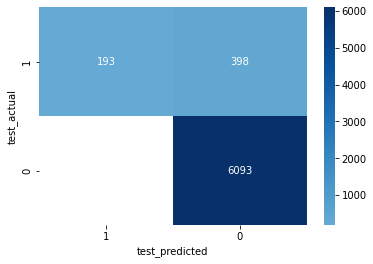

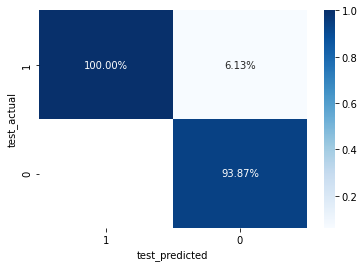

In [200]:
keras_predict_df = pd.DataFrame(y_test, columns=['test_actual'])
keras_predict_df['test_predicted'] = y_predicted
keras_predict_df['test_predicted'] = keras_predict_df['test_predicted'].astype(int)
keras_predict_df.reset_index().groupby(['test_actual', 'test_predicted']).count()[['index']].reset_index().pivot(index='test_actual', columns='test_predicted', values='index').sort_values(by=['test_actual'], ascending=False)
df_matrix = keras_predict_df.reset_index().groupby(['test_actual', 'test_predicted']).count()[['index']].reset_index().pivot(index='test_actual', columns='test_predicted', values='index').sort_values(by=['test_actual'], ascending=False).loc[:,(1,0)]
sns.heatmap(df_matrix, annot=True, center=True,cmap='Blues', fmt='g')
plt.show()
sns.heatmap(df_matrix/np.sum(df_matrix), annot=True,
            fmt='.2%', cmap='Blues')
plt.show()

In [203]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
df_plot = df_plot.append(pd.DataFrame({'Model_id': 'Keras_GPU',
                            'AUC': int(roc_auc_score(y_test, y_predicted)*100)/100,
                            'F1': int(f1_score(y_test, y_predicted)*100)/100,
                            'Accuracy': int(accuracy_score(y_test, y_predicted)*100)/100
                            }, index=[0]))

## 4.2.1 Keras Submision dataset

In [233]:
submission_normalized_and_dummy_df = pd.read_csv('./HR_Analytics/submission_normalized_and_dummy_df.csv')
x_submission = submission_normalized_and_dummy_df.loc[:, (normalized_and_dummy)].to_numpy()

In [234]:
y_submission = model_keras.predict(x_submission)
y_submission[y_submission <= 0.5] = 0
y_submission[y_submission > 0.5] = 1

735/735 [==============================] - 1s 1ms/step


In [235]:
submission_normalized_and_dummy_df[VarTarget] = y_submission
submission_normalized_and_dummy_df[VarTarget] = submission_normalized_and_dummy_df[VarTarget].astype(int)
submission_normalized_and_dummy_df.loc[:, (VarId, VarTarget)].loc[:, (VarId, VarTarget)].to_csv('./HR_Analytics/results/Keras_submission.csv', index=False)
submission_normalized_and_dummy_df[VarTarget].value_counts()

0    22900
1      590
Name: is_promoted, dtype: int64

## 4.3 XGBosst

In [91]:
from xgboost import XGBClassifier
# read data
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
data = load_iris()
X_train, X_test, y_train, y_test = train_test_split(data['data'], data['target'], test_size=.2)
# create model instance
bst = XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic')
# fit model
bst.fit(X_train, y_train)
# make predictions
preds = bst.predict(X_test)

[00:16:03] WARNING: /mnt/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/anaconda/envs/azureml_py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [93]:
%pip install hyperopt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 11.5 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.5/200.5 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 18.5 MB/s eta 0:00:00:00:01
Note: you may need to restart the kernel to use updated packages.


In [116]:
# import pandas for data wrangling
import pandas as pd


# import numpy for Scientific computations
import numpy as np


# import machine learning libraries
import xgboost as xgb
from sklearn.metrics import accuracy_score


# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

In [117]:
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

In [118]:
def objective(space):
    clf=xgb.XGBClassifier(use_label_encoder=False,
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( x_train, y_train), (x_test, y_test)]
    
    clf.fit(x_train, y_train,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(x_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [119]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

SCORE:                                                 
0.9163798716398475                                     
SCORE:                                                                            
0.9163798716398475                                                                
SCORE:                                                                            
0.9163798716398475                                                                
SCORE:                                                                            
0.9163798716398475                                                                
SCORE:                                                                            
0.9163798716398475                                                                
SCORE:                                                                            
0.9163798716398475                                                                
SCORE:                                                    

In [113]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.610488153507855, 'gamma': 7.414903050280333, 'max_depth': 3.0, 'min_child_weight': 4.0, 'reg_alpha': 73.0, 'reg_lambda': 0.22814961763224073}


In [123]:
clf=xgb.XGBClassifier(use_label_encoder=False,
                      colsample_bytree=0.610488153507855,
                      gamma=7.414903050280333,
                      max_depth= 3,
                      min_child_weight= 4,
                      reg_alpha= 73,
                      reg_lambda= 0.22814961763224073)
evaluation = [( x_train, y_train), (x_test, y_test)]

clf.fit(x_train, y_train,
        eval_set=evaluation, eval_metric="aucpr",
        early_stopping_rounds=10,verbose=False)


pred = clf.predict(x_test)

In [125]:
pred = clf.predict(x_test)
accuracy = accuracy_score(y_test, pred>0.5)
accuracy

0.9320063249930239

## 4.3 Compare performance on the TEST dataset for all trained models

In [42]:
#Create empty model list
list_models = []

#Define the list of all models that have been executed and should be compared
try:
    list_models.append(sm_predictor)
except NameError:
    pass
try:
    list_models.append(h2o_champion)
except NameError:
    pass
try:
    list_models.append(best_AutoML)
except NameError:
    pass

In [43]:
#Consider all models in the history ./models/candidates/performance_*.csv. To disregard any old version, set erase_modelos = "S":
apagar_modelos = 'N'
if apagar_modelos == 'S':
    os.system('rm %s/models/candidates/performance_*.csv' % OutputPath)

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


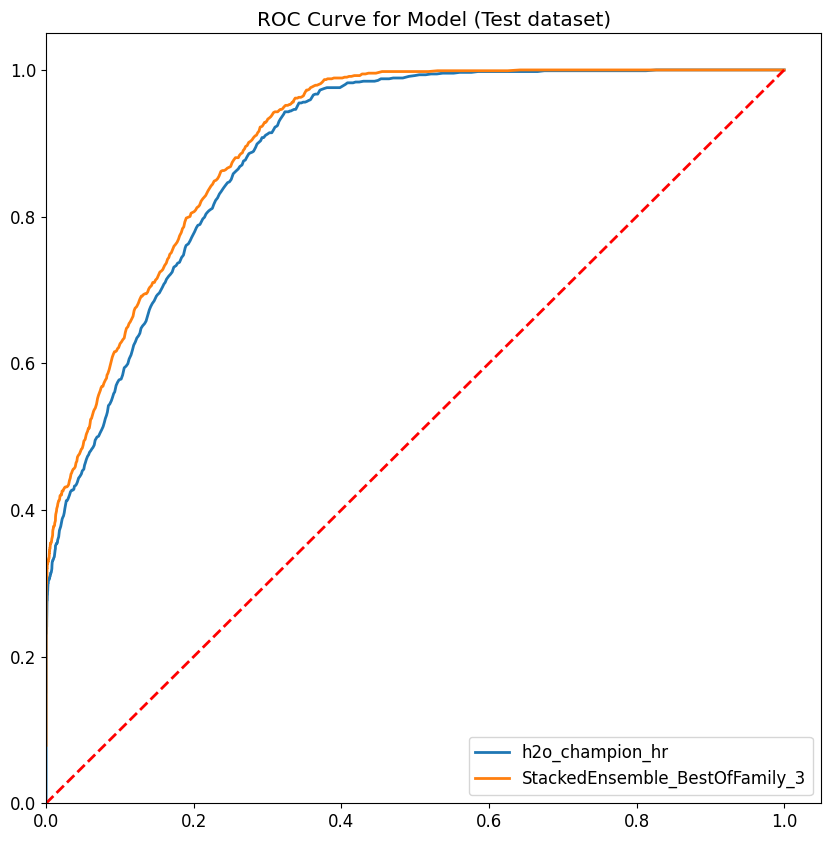

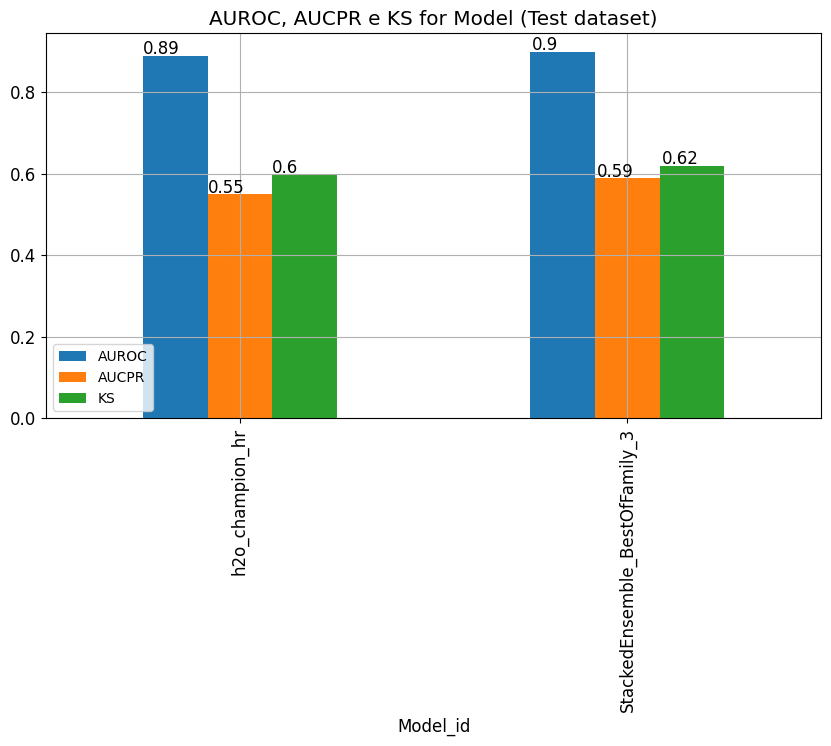

In [44]:
#Compare performance on the TEST dataset for all trained models
plt.rcParams.update({'font.size': 12})
fig = plt.figure(figsize=(10, 10))
for i in list_models:    
    if (isinstance(i, h2o.estimators.gbm.H2OGradientBoostingEstimator)) | (isinstance(i, h2o.estimators.stackedensemble.H2OStackedEnsembleEstimator)):
        #Save all models in H20 format
        h2o.save_model(model=i, path='%s/models/candidates/' % OutputPath, force=True)
        #calculate o KS in test dataset
        h2o_predict = i.predict(test_hdf)
        data = h2o_predict.cbind(test_hdf[VarTarget]).as_data_frame()
        data['target0'] = 1 - data[VarTarget]
        data['bucket'] = pd.qcut(data['p1'], 10, duplicates='drop', labels=False)
        grouped = data.groupby('bucket', as_index=False)
        kstable = pd.DataFrame()
        kstable['min_prob'] = grouped.min()['p1']
        kstable['max_prob'] = grouped.max()['p1']
        kstable['events'] = grouped.sum()[VarTarget]
        kstable['nonevents'] = grouped.sum()['target0']    
        kstable = kstable.sort_values(by="min_prob", ascending=False).reset_index(drop=True)
        kstable['event_rate'] = (kstable.events / data[VarTarget].sum()).apply('{0:.2%}'.format)
        kstable['nonevent_rate'] = (kstable.nonevents / data['target0'].sum()).apply('{0:.2%}'.format)
        kstable['cum_eventrate'] = (kstable.events / data[VarTarget].sum()).cumsum()
        kstable['cum_noneventrate'] = (kstable.nonevents / data['target0'].sum()).cumsum()
        kstable['KS'] = np.round(kstable['cum_eventrate'] - kstable['cum_noneventrate'], 3)
        ks = kstable['KS'].max()

        #Ascertain the performance of all models on the test base
        performance = i.model_performance(test_hdf)

        #Salve metrics
        f=open("%s/models/candidates/performance_%s.csv" % (OutputPath, i.model_id), 'w')
        f.write(
            str(i.model_id) + ";"
            + str(performance.accuracy()[0][0]) + ";"
            + str(performance.auc()) + ';'
            + str(performance.aucpr()) + ';'
            + str(performance.logloss()) + ';'
            + str(ks) + ';'
            + str(performance.F1()[0][0]))
        f.write('\n')
        f.close()

        #graph with the ROC curve of all models
        fpr = performance.fprs
        tpr = performance.tprs
        plt.plot(fpr, tpr, lw=2, label=i.model_id.split("_")[0]+"_"+i.model_id.split("_")[1]+"_"+i.model_id.split("_")[2])
        plt.title("ROC Curve for Model (Test dataset)")    

        if i == list_models[0]:
            df_plot = pd.DataFrame({'Model_id': i.model_id.split("_")[0]+"_"+i.model_id.split("_")[1]+"_"+i.model_id.split("_")[2],
                                        'AUROC': int(performance.auc()*100)/100,
                                        'AUCPR': int(performance.aucpr()*100)/100,
                                        'KS': int(ks*100)/100
                                        }, index=[0])
        else:
            df_plot = df_plot.append(pd.DataFrame({'Model_id': i.model_id.split("_")[0]+"_"+i.model_id.split("_")[1]+"_"+i.model_id.split("_")[2],
                                        'AUROC': int(performance.auc()*100)/100,
                                        'AUCPR': int(performance.aucpr()*100)/100,
                                        'KS': int(ks*100)/100
                                        }, index=[0]))
            
    elif isinstance(i, sagemaker.predictor.Predictor):
        #Save model
        model_id = (sm.describe_endpoint_config(EndpointConfigName=sm.describe_endpoint(EndpointName=i.endpoint_name)['EndpointConfigName'])['ProductionVariants'][0]['ModelName'])
        text_file = open("%s/models/candidates/%s.py" % (OutputPath, model_id), "w")        
        text_file.write("""#recreate create_endpoint_config and create_endpoint for model %s
epc_name = "%s"
ep_config = sm.create_endpoint_config(
    EndpointConfigName=epc_name,
    ProductionVariants=[
        {
            "InstanceType": "ml.m5.2xlarge",
            "InitialInstanceCount": 1,
            "ModelName": "%s",
            "VariantName": "main",
        }
    ],
)

#Create end endpoint
ep_name = "%s"
create_endpoint_response = sm.create_endpoint(EndpointName=ep_name, EndpointConfigName=epc_name)
sm.get_waiter("endpoint_in_service").wait(EndpointName=ep_name)
print("ep_name: " + str(ep_name))

sm_predictor = Predictor(
    endpoint_name="%s",
    sagemaker_session=session,
    serializer=CSVSerializer(),
    deserializer=CSVDeserializer(),)""" % (model_id,
                                        model_id.replace('-model', '-epc'),
                                        model_id,
                                        model_id.replace('-model', '-ep'),
                                        model_id.replace('-model', '-ep')       
                                       )
                       )
        text_file.close()
        
        sm_predict = pd.DataFrame(i.predict(dataprep_df.query('partition_0 == "test_data"').loc[:, (selected_features)].to_csv(sep=",", header=False, index=False)))
        sm_predict.columns = ['predict', 'p1', 'probabilities']
        sm_predict['predict'] = sm_predict['predict'].astype(int)
        sm_predict['p1'] = sm_predict['p1'].astype(float)

        data = pd.concat([sm_predict.reset_index(drop=True), dataprep_df.query('partition_0 == "test_data"').reset_index(drop=True)[VarTarget]], axis=1)
        data['target0'] = 1 - data[VarTarget]
        data['bucket'] = pd.qcut(data['p1'], 10, duplicates='drop', labels=False)
        grouped = data.groupby('bucket', as_index=False)
        kstable = pd.DataFrame()
        kstable['min_prob'] = grouped.min()['p1']
        kstable['max_prob'] = grouped.max()['p1']
        kstable['events'] = grouped.sum()[VarTarget]
        kstable['nonevents'] = grouped.sum()['target0']
        kstable = kstable.sort_values(by="min_prob", ascending=False).reset_index(drop=True)
        kstable['event_rate'] = (kstable.events / data[VarTarget].sum()).apply('{0:.2%}'.format)
        kstable['nonevent_rate'] = (kstable.nonevents / data['target0'].sum()).apply('{0:.2%}'.format)
        kstable['cum_eventrate'] = (kstable.events / data[VarTarget].sum()).cumsum()
        kstable['cum_noneventrate'] = (kstable.nonevents / data['target0'].sum()).cumsum()
        kstable['cum_eventrate'] = kstable['cum_eventrate'].astype(float)
        kstable['cum_noneventrate'] = kstable['cum_noneventrate'].astype(float)
        kstable['KS'] = np.round(kstable['cum_eventrate'] - kstable['cum_noneventrate'], 3)
        ks = kstable['KS'].max()
        
        accuracy = metrics.accuracy_score(dataprep_df.query('partition_0 == "test_data"').reset_index(drop=True)[VarTarget].astype(str), sm_predict['predict'].astype(str))
        fpr, tpr, thresholds = metrics.roc_curve(dataprep_df.query('partition_0 == "test_data"').reset_index(drop=True)[VarTarget].astype(int), sm_predict['predict'].astype(int), pos_label=1)
        auc = metrics.auc(fpr, tpr)
        aucpr = metrics.average_precision_score(dataprep_df.query('partition_0 == "test_data"').reset_index(drop=True)[VarTarget].astype(int), sm_predict['predict'].astype(int), pos_label=1)
        f1 = metrics.f1_score(dataprep_df.query('partition_0 == "test_data"').reset_index(drop=True)[VarTarget].astype(str), sm_predict['predict'].astype(str), pos_label='1')
        log_loss = metrics.log_loss(dataprep_df.query('partition_0 == "test_data"').reset_index(drop=True)[VarTarget].astype(str), sm_predict['predict'].astype(str))
        
        #Salve metrics
        f=open("%s/models/candidates/performance_%s.csv" % (OutputPath, model_id), 'w')
        f.write(
            str(model_id) + ";"
            + str(accuracy) + ";"
            + str(auc) + ';'
            + str(aucpr) + ';'
            + str(log_loss) + ';'
            + str(ks) + ';'
            + str(f1))
        f.write('\n')
        f.close()
        
        plt.plot(fpr, tpr, lw=2, label=model_id.split("-")[0]+"-"+model_id.split("-")[1]+"-"+model_id.split("-")[2])
        plt.title("ROC Curve for Model (Test dataset)")
        
        if i == list_models[0]:
            df_plot = pd.DataFrame({'Model_id': model_id.split("-")[0]+"-"+model_id.split("-")[1]+"-"+model_id.split("-")[2],
                                        'AUROC': int(auc*100)/100,
                                        'AUCPR': int(aucpr*100)/100,
                                        'KS': int(ks*100)/100
                                        }, index=[0])
        else:
            df_plot = df_plot.append(pd.DataFrame({'Model_id': model_id.split("-")[0]+"-"+model_id.split("-")[1]+"-"+model_id.split("-")[2],
                                        'AUROC': int(auc*100)/100,
                                        'AUCPR': int(aucpr*100)/100,
                                        'KS': int(ks*100)/100
                                        }, index=[0]))
        
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.legend(loc="lower right")
plt.show()
plt.close()
ax = df_plot.plot(kind='bar', x="Model_id", title="AUROC, AUCPR e KS for Model (Test dataset)", grid=True, figsize=(10,5), legend=1)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.legend(loc=3, prop={'size': 10})

## 4.4 Choose the best model among all tested

In [49]:
sort_metric_best_model='F1'
#import all tested models and print the 10 bests sorted by AUC on the screen
modelos_testados = pd.concat(map(functools.partial(pd.read_csv, sep=';', header=None), glob.glob('%s/models/candidates/performance_*.csv' % OutputPath)))
modelos_testados.columns = ('model_id', 'accuracy', 'AUC', 'AUCPR', 'logloss', 'KS', 'F1')
modelos_testados = modelos_testados.sort_values(by=sort_metric_best_model, ascending=False)
modelos_testados = modelos_testados.drop_duplicates(subset=["model_id"])
print('MBest Models. Sorted by : ' + str(sort_metric_best_model))
modelos_testados.reset_index(0).head(30)

MBest Models. Sorted by : F1


,index,model_id,accuracy,AUC,AUCPR,logloss,KS,F1
0,0,StackedEnsemble_BestOfFamily_1_AutoML_1_20221104_232231,0.605805,0.898887,0.573128,0.171703,0.618,0.348232
1,0,StackedEnsemble_BestOfFamily_3_AutoML_2_20221104_234313,0.495347,0.904213,0.591509,0.164896,0.620,0.261152
2,0,h2o_champion_hr_analytics_v1_20221104_234252,0.379686,0.891647,0.551111,0.181936,0.606,0.234451
3,0,h2o_champion_hr_analytics_v1_20221104_232202,0.379686,0.891647,0.551111,0.181936,0.606,0.234451


In [62]:
#If you want to choose a model other than the first one on the list. Choose the position number:
posicao_melhor_modelo=0

plt.rcParams.update({'font.size': 10})
try:
    melhor_modelo = h2o.load_model('%s/models/candidates/%s' % (OutputPath, modelos_testados.iloc[posicao_melhor_modelo, 0]))
    (print("\n"+ "BEST MODEL: " + str(modelos_testados.iloc[posicao_melhor_modelo, 0]) + "\n"))
    
    melhor_modelo.varimp_plot(50)
except Exception as e:
    print(e)    
    (print("\n"+ "BEST MODEL: " + str(modelos_testados.iloc[posicao_melhor_modelo, 0]) + "\n"))
    print("Warning: This model doesn't have variable importances")


BEST MODEL: StackedEnsemble_BestOfFamily_1_AutoML_1_20221104_232231

Variable importance plot is not available for this type of model (stackedensemble).

BEST MODEL: StackedEnsemble_BestOfFamily_1_AutoML_1_20221104_232231



## 4.5 Stepwise for Analysis of the importance of variables and reduce the number of variables in the best model (Only for H2O)

In [52]:
#List all variables in the current model, ordered by variable importance
#For variables defined as a factor (which possibly are like dummys), remove the category from the name and leave only the orifinal name of the variable
try:
    df_features_sorted = melhor_modelo.varimp(True).variable.str.split('.', expand=True).drop_duplicates(subset = 0)[0].reset_index(drop=True).to_list()
except Exception as e:
    #As the model with ensemble in H20 does not show the importance of variables, we will include variables in selected_features
    df_features_sorted = selected_features

In [53]:
#Define the number of variables to be increased with each new model. Try to put 10% or 20% of the total, as it can take a long time
qt_var=1
qt_total_var = len(df_features_sorted)

dict_model_tmp={}
dict_performance={}

for i in range(qt_var, qt_total_var+qt_var, qt_var):    
    df_features_sorted[0:i]
    
    #If no model chosen is not an ensemble of models. Then use the same model for training with increment of variables
    melhor_modelo_tmp = melhor_modelo
    if melhor_modelo_tmp.model_id.lower().find("ensemble") == -1:
        dict_model_tmp[i] = melhor_modelo_tmp
        dict_model_tmp[i].train(x = df_features_sorted[0:i],
                                y = VarTarget,
                                training_frame=train_hdf, 
                                validation_frame=valid_hdf)
    ##If it is not possible, for the home of an ensemble of models, use GradientBoostingEstimator to make the assessment
    else:
        dict_model_tmp[i] = H2OGradientBoostingEstimator(seed=1, model_id=str('model_tmp_%s' % i))
        dict_model_tmp[i].train(x = df_features_sorted[0:i],
                                y = VarTarget,
                                training_frame=train_hdf, 
                                validation_frame=valid_hdf)       


    perform_oot = dict_model_tmp[i].model_performance(test_hdf)
    dict_performance_tmp = {}
    dict_performance_tmp['AUC'] = {'qt_var': i, 'medida': 'AUC', 'Validation_Dataset': dict_model_tmp[i].auc(valid=True), 'Test_Dataset': perform_oot.auc()}
    dict_performance_tmp['accuracy'] = {'qt_var': i, 'medida': 'accuracy', 'Validation_Dataset': dict_model_tmp[i].accuracy(valid=True)[0][0], 'Test_Dataset': perform_oot.accuracy()[0][0]}
    dict_performance_tmp['AUCPR'] = {'qt_var': i, 'medida': 'AUCPR', 'Validation_Dataset': dict_model_tmp[i].aucpr(valid=True), 'Test_Dataset': perform_oot.aucpr()}
    dict_performance_tmp['F1'] = {'qt_var': i, 'medida': 'F1', 'Validation_Dataset': dict_model_tmp[i].F1(valid=True)[0][0], 'Test_Dataset': perform_oot.F1()[0][0]}
    dict_performance_tmp['logloss'] = {'qt_var': i, 'medida': 'logloss', 'Validation_Dataset': dict_model_tmp[i].logloss(valid=True), 'Test_Dataset': perform_oot.logloss()}
    dict_performance[i] = pd.DataFrame(dict_performance_tmp).transpose()

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |███████████████████████

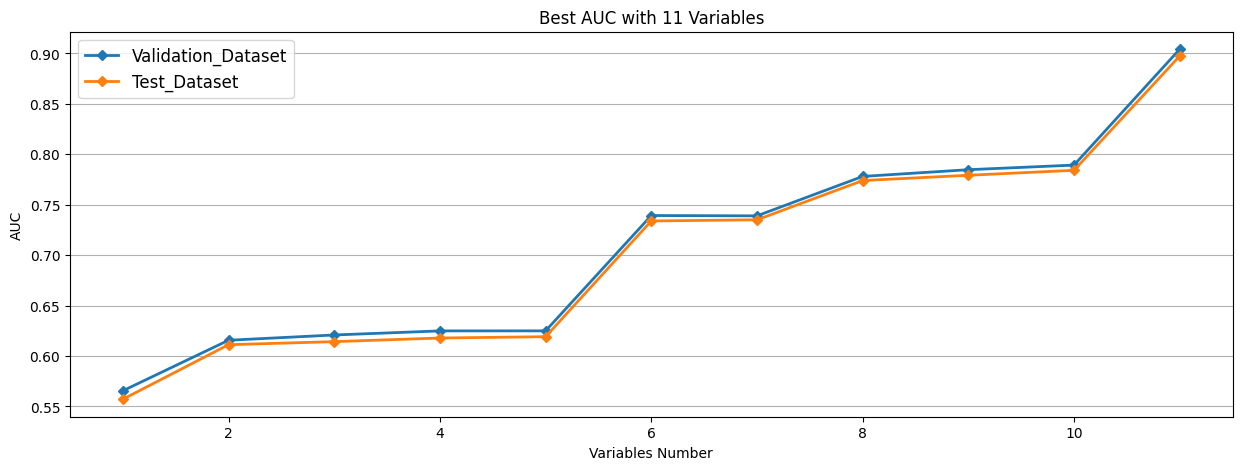

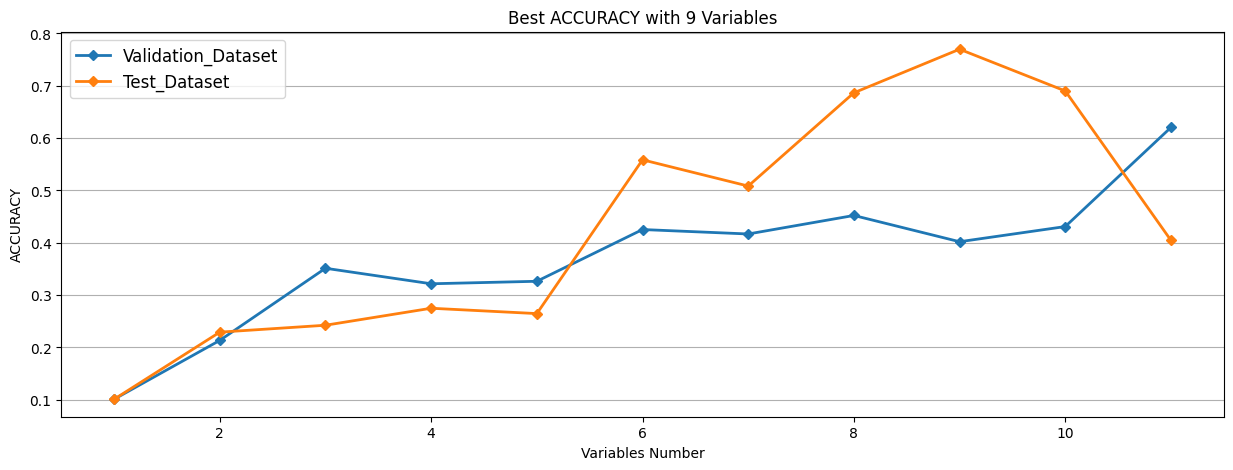

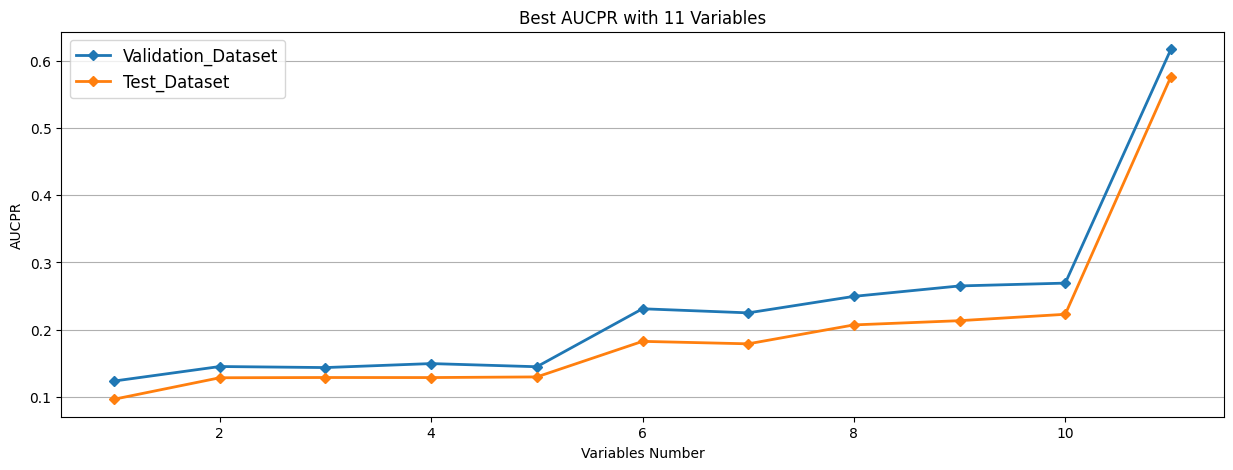

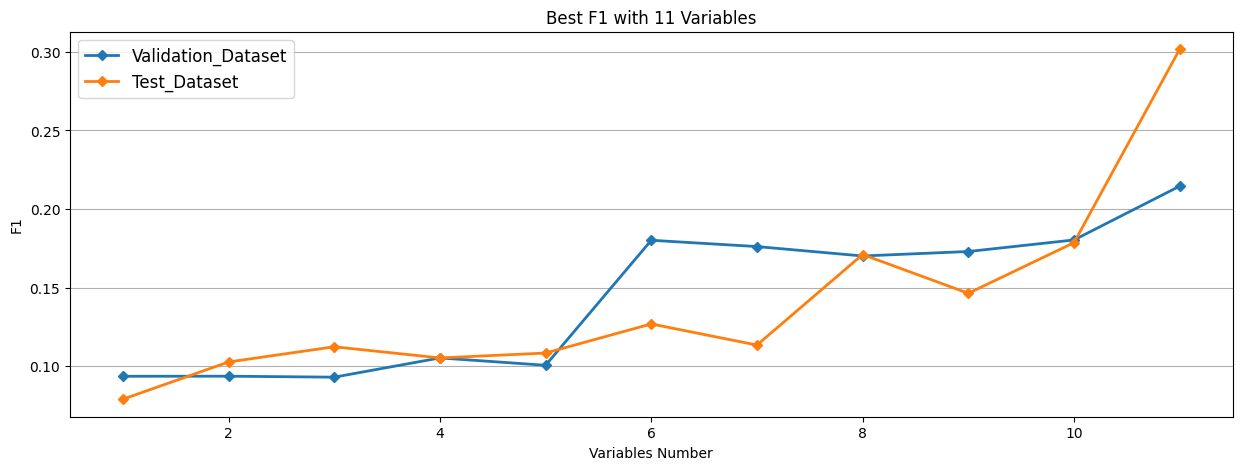

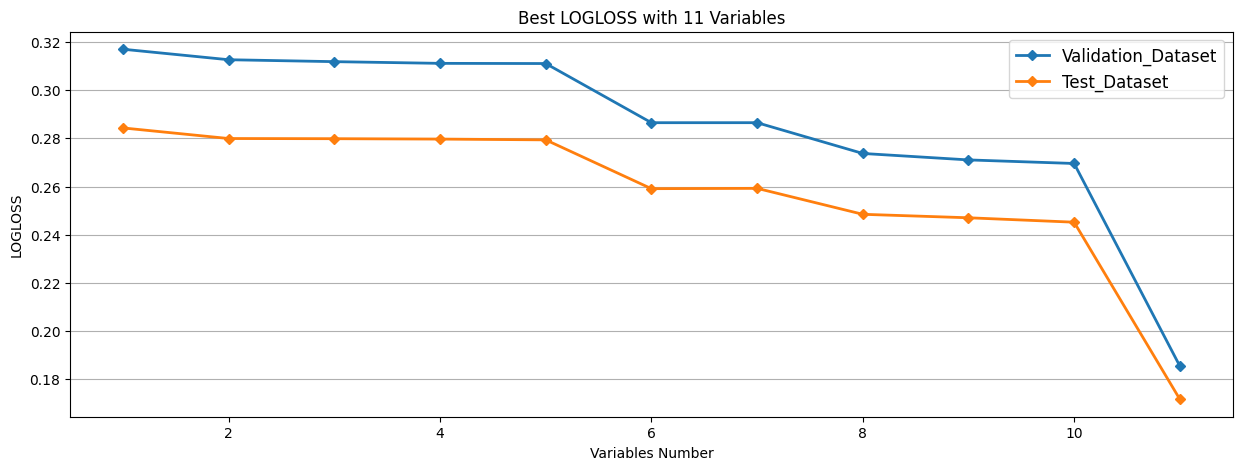

In [54]:
##Plot graph comparing the increase in performance with the increase in variables
for i in dict_performance.keys():
    if i == list(dict_performance.keys())[0]:
        df_performance = dict_performance[i]
    else:
        df_performance = df_performance.append(dict_performance[i], ignore_index=True)

lista_metricas_perf = df_performance['medida'].unique()

for i in range(len(lista_metricas_perf)):   
    #selects only the metric to be analyzed
    metrics_df_tmp = df_performance.query('medida == "%s"' % lista_metricas_perf[i])
    metrics_df_tmp = metrics_df_tmp.set_index('qt_var')
    del metrics_df_tmp['medida']
    if lista_metricas_perf[i] == 'logloss':
        max_oot = metrics_df_tmp[metrics_df_tmp['Test_Dataset'] == metrics_df_tmp.Test_Dataset.min()].index.values
    else:
        max_oot = metrics_df_tmp[metrics_df_tmp['Test_Dataset'] == metrics_df_tmp.Test_Dataset.max()].index.values
        
    if lista_metricas_perf[i] == sort_metric_best_model:
        max_oot_filtro = max_oot[0]        
    
    ax=metrics_df_tmp.plot(figsize=(15,5), linewidth=2, fontsize=10, marker='D', ms=5,\
                            title='Best %s with %s Variables' % (lista_metricas_perf[i].upper(), str(max_oot[0])))
    plt.xlabel('Variables Number')
    plt.ylabel('%s' % lista_metricas_perf[i].upper())
    plt.grid(axis='y')
    plt.legend(loc=0, prop={'size': 12})
    #display(ax)

In [55]:
print('Consider using only the following variables: '+ str(df_features_sorted[0:int(max_oot_filtro)]))

Consider using only the following variables: ['department', 'region', 'education', 'gender', 'recruitment_channel', 'kpis_met_80', 'no_of_trainings', 'previous_year_rating', 'age', 'length_of_service', 'avg_training_score']


# 5. Exporting the best model to Deploy (Usar o path_model_mojo para o código 3_Explaining_Model.ipynb)

In [56]:
try:
    #Save the H2O model in MOJO format and all the variables of the best model
    melhor_modelo = h2o.load_model('%s/models/candidates/%s' % (OutputPath, modelos_testados.iloc[posicao_melhor_modelo, 0]))
    path_model_mojo = melhor_modelo.download_mojo('%s/models/best/' % OutputPath, get_genmodel_jar=True)
    print('path_model_mojo: ' + str(path_model_mojo))
    caminho_modelo_h2o = h2o.save_model(model=melhor_modelo, path='%s/models/best/' % OutputPath, force=True)
except Exception as e:
    src_path = "%s/models/candidates/%s.py" % (OutputPath, ModelId)
    dst_path = "%s/models/best/%s.py" % (OutputPath, ModelId)
    shutil.copy(src_path, dst_path)
    print('path_sagemaker_model: ' + str(dst_path))

path_model_mojo: /home/sagemaker-user/FIEP-Modelos-de-Aprendizado-e-Arquiteturas-Cloud/projeto_final/output_model/models/best/StackedEnsemble_BestOfFamily_1_AutoML_1_20221104_232231.zip


Detected 1 unused columns in the input data set: {}


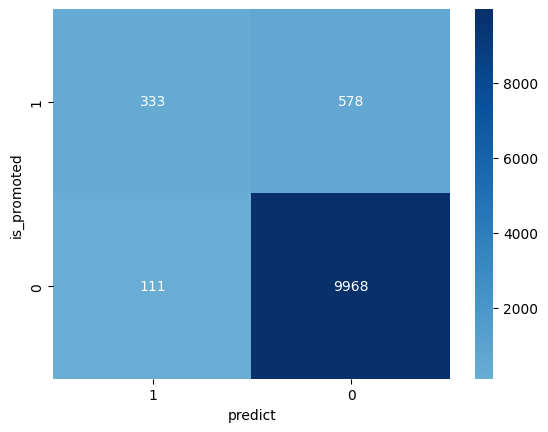

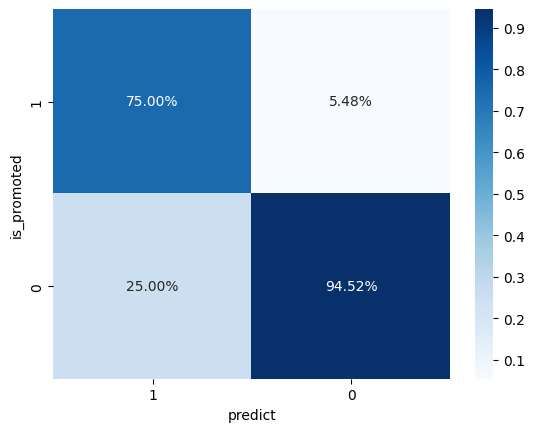

In [57]:
#Confusion Matrix for the Champion
df_predict_tmp = h2o.mojo_predict_pandas(dataprep_df.query('partition_0 == "test_data"').loc[:, (selected_features+[VarTarget])], mojo_zip_path=path_model_mojo, verbose=False)

df_predict = pd.concat([df_predict_tmp.reset_index(drop=True), dataprep_df.query('partition_0 == "test_data"').loc[:, (selected_features+[VarTarget])].reset_index(drop=True)], axis=1)

df_matrix = df_predict.reset_index().groupby([VarTarget, 'predict']).count()[['index']].reset_index().pivot(index=VarTarget, columns='predict', values='index').sort_values(by=[VarTarget], ascending=False).loc[:,(1,0)]

sns.heatmap(df_matrix, annot=True, center=True,cmap='Blues', fmt='g')
plt.show()
sns.heatmap(df_matrix/np.sum(df_matrix), annot=True,
            fmt='.2%', cmap='Blues')
plt.show()

## 5.1 Cleaning Resources

In [58]:
# sm.delete_endpoint(EndpointName=ep_name)
# sm.delete_endpoint_config(EndpointConfigName=epc_name)

# 6. Save final dataset with predictions into S3 to explain the model

In [59]:
csv_buffer = StringIO()
df_predict.to_csv(csv_buffer, index=False, header=True)
s3_resource = my_boto3_session.resource('s3')
s3_resource.Object(bucket, 'databases/%s/%s.csv' % (ModelName+'_scored', ModelName+'_scored')).put(Body=csv_buffer.getvalue())
del csv_buffer

In [60]:
glue = my_boto3_session.client('glue', region_name="us-east-1")

try:
    glue.delete_table(
        DatabaseName='auladeploymodelos',
        Name=ModelName+'_scored'
    )
except:
    print("table does not exist e sera criada pela primeira vez")

glue.update_crawler(Name='aula-deploy-modelos',
                    Targets={'S3Targets': [{'Path': 's3://%s/databases/%s' % (bucket, ModelName+'_scored'),
                               'Exclusions': []}]})

glue.start_crawler(Name='aula-deploy-modelos')

{'ResponseMetadata': {'RequestId': '8afe291d-8965-4162-8316-f961ceb03d8b',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Sat, 05 Nov 2022 00:38:14 GMT',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '2',
   'connection': 'keep-alive',
   'x-amzn-requestid': '8afe291d-8965-4162-8316-f961ceb03d8b'},
  'RetryAttempts': 0}}